In [3]:
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchjpeg import dct
from PIL import Image
import seaborn as sns
import numpy as np
import torch
import math
import cv2
import os

/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
block_size = 4
total_frequency_component = block_size * block_size

overall_img_path_list = []
path_prefix = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/"
all_dir = os.listdir(path_prefix)
# print(all_dir)
for sgl_dir in all_dir:
    path_average = os.path.join(path_prefix + sgl_dir, "average")
        # print(os.path.join(path_average, image))
    overall_img_path_list.append(os.path.join(path_average, os.listdir(path_average)[0]))
    
def img_reorder(x, bs, ch, h, w):
    x = (x + 1) / 2 * 255
    assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")
    x = dct.to_ycbcr(x)  # comvert RGB to YCBCR
    x -= 128
    x = x.view(bs * ch, 1, h, w)
    x = F.unfold(x, kernel_size=(block_size, block_size), dilation=1, padding=0, stride=(block_size, block_size))
    x = x.transpose(1, 2)
    x = x.view(bs, ch, -1, block_size, block_size)
    return x

## Image reordering and testing
def img_inverse_reroder(coverted_img, bs, ch, h, w):
    x = coverted_img.view(bs* ch, -1, total_frequency_component)
    x = x.transpose(1, 2)
    x = F.fold(x, output_size=(h, w), kernel_size=(block_size, block_size), stride=(block_size, block_size))
    x += 128
    x = x.view(bs, ch, h, w)
    x = dct.to_rgb(x)#.squeeze(0)
    x = (x / 255.0) * 2 - 1
    return x

def calculate_block_mse(downsample_in, freq_block, num_freq_component=block_size):
    downsample_img = transforms.Resize(size=int(downsample_in.shape[-1]/num_freq_component))(downsample_in)
    assert(downsample_img.shape == freq_block[:,:,0,:,:].shape, "downsample input shape does not match the shape of post-BDCT component")
    loss_vector = torch.zeros(freq_block.shape[2])
    for i in range(freq_block.shape[2]):
        # calculate the MSE between each frequency components and given input downsampled images
        loss_vector[i] = F.mse_loss(downsample_img, freq_block[:,:,i,:,:])
    return loss_vector

def bdct_4x4(img_path):
    # The original input image comes with it and I disable it to reduce the computation overhead.
    # x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=True)
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    x = transform(image).unsqueeze(0)

    back_input = x
    bs, ch, h, w = x.shape
    block_num = h // block_size
    x = img_reorder(x, bs, ch, h, w)
    dct_block = dct.block_dct(x) # BDCT
    dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, total_frequency_component).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)

    return  dct_block_reorder

def private_freq_component_thres_based_selection(img_path, mse_threshold):
    # The original input image comes with it and I disable it to reduce the computation overhead.
    # x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=True)
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    x = transform(image).unsqueeze(0)

    back_input = x
    bs, ch, h, w = x.shape
    block_num = h // block_size
    x = img_reorder(x, bs, ch, h, w)
    dct_block = dct.block_dct(x) # BDCT
    dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, total_frequency_component).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)
    loss_vector = calculate_block_mse(back_input, dct_block_reorder)
    # Split all component based on the frequency
    private_idx = torch.where(loss_vector > mse_threshold)[0]
    public_idx = []
    all_possible_idx = [i for i in range(total_frequency_component)]
    for element in all_possible_idx:
        if element not in private_idx:
            public_idx.append(element)

    return private_idx,  torch.Tensor(public_idx).to(torch.int64), dct_block_reorder

<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:37: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:37: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:37: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_365683/470356363.py:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")
/tmp/ipykernel_365683/470356363.py:37: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(downsample_img.shape == freq_block[:,:,0,:,:].shape, "downsample input shape does not match the shape of post-BDCT component")


# Obtain User 1 -- highest frequency components

In [5]:
overall_img_path_list = []
path_prefix = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/"
all_dir = os.listdir(path_prefix)
for sgl_dir in all_dir:
    path_average = os.path.join(path_prefix + sgl_dir, "average")
    overall_img_path_list.append(os.path.join(path_average, os.listdir(path_average)[0]))

In [6]:
highest_frequency_components_list = []
for img_path in overall_img_path_list:
    img_blocks = bdct_4x4(img_path)
    highest_frequency_components_list.append(img_blocks[:,:,-1,:,:])

In [7]:
# L2 norm among highest frequency components after BDCT decomposition
num_images = len(highest_frequency_components_list)

l2_norm_expression_list = np.zeros((len(highest_frequency_components_list),len(highest_frequency_components_list)))
for i in range(num_images):
    for j in range(num_images):
        l2_norm_expression_list[i][j] = np.linalg.norm(highest_frequency_components_list[i] - highest_frequency_components_list[j])

(array([2., 0., 0., ..., 0., 0., 2.]),
 array([161.07901001, 161.14125002, 161.20349002, ..., 285.43454099,
        285.49678099, 285.559021  ]),
 <BarContainer object of 2000 artists>)

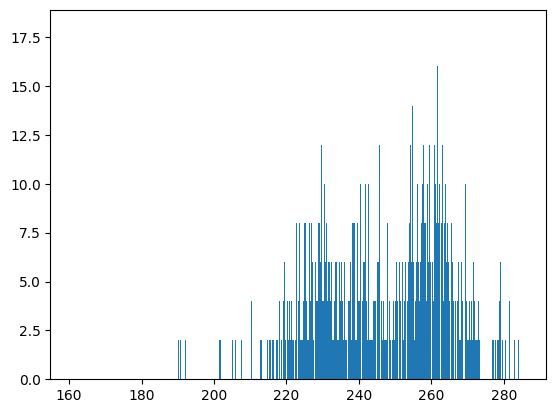

In [6]:
import matplotlib.pyplot as plt
(row, col) = np.nonzero(l2_norm_expression_list)
l2_norm_non_zero_expression_list = l2_norm_expression_list[row, col]
plt.hist(l2_norm_non_zero_expression_list, bins=2000)

(array([2., 0., 0., ..., 0., 0., 2.]),
 array([0.13197051, 0.1321119 , 0.13225329, ..., 0.41447149, 0.41461288,
        0.41475427]),
 <BarContainer object of 2000 artists>)

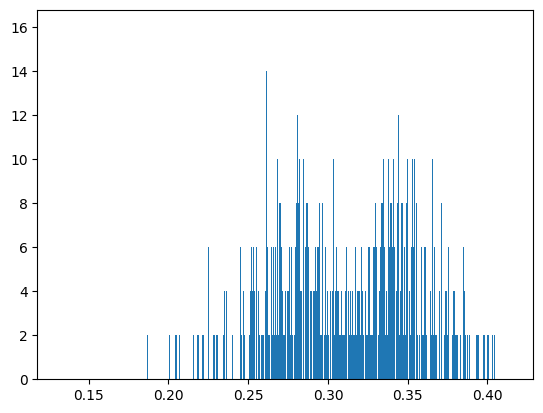

In [18]:
num_images = len(highest_frequency_components_list)

mse_expression_list = np.zeros((len(highest_frequency_components_list),len(highest_frequency_components_list)))
for i in range(num_images):
    for j in range(num_images):
        mse_expression_list[i][j] = np.square(highest_frequency_components_list[i] - highest_frequency_components_list[j]).mean()
        
mse_expression_array = np.array(mse_expression_list)

import matplotlib.pyplot as plt
(row, col) = np.nonzero(mse_expression_list)
mse_non_zero_expression_list = mse_expression_array[row, col]
plt.hist(mse_non_zero_expression_list, bins=2000)

# Obtain User 2 -- highest frequency components

In [9]:
overall_img_path_list2 = []
path_prefix2 = "/scratch1/jianming/multiface/dataset/m--20180226--0000--6674443--GHS/unwrapped_uv_1024/"
all_dir = os.listdir(path_prefix2)
for sgl_dir in all_dir:
    path_average2 = os.path.join(path_prefix2 + sgl_dir, "average")
    overall_img_path_list2.append(os.path.join(path_average2, os.listdir(path_average2)[0]))

In [10]:
highest_frequency_components_list2 = []
for img_path in overall_img_path_list2:
    img_blocks = bdct_4x4(img_path)
    highest_frequency_components_list2.append(img_blocks[:,:,-1,:,:])

In [11]:
# L2 norm among highest frequency components after BDCT decomposition
num_images = len(highest_frequency_components_list2)

l2_norm_expression_list2 = np.zeros((len(highest_frequency_components_list2),len(highest_frequency_components_list2)))
for i in range(num_images):
    for j in range(num_images):
        l2_norm_expression_list2[i][j] = np.linalg.norm(highest_frequency_components_list2[i] - highest_frequency_components_list2[j])

(array([2., 0., 0., ..., 0., 0., 2.]),
 array([176.69187927, 176.72934146, 176.76680365, ..., 251.54133234,
        251.57879453, 251.61625671]),
 <BarContainer object of 2000 artists>)

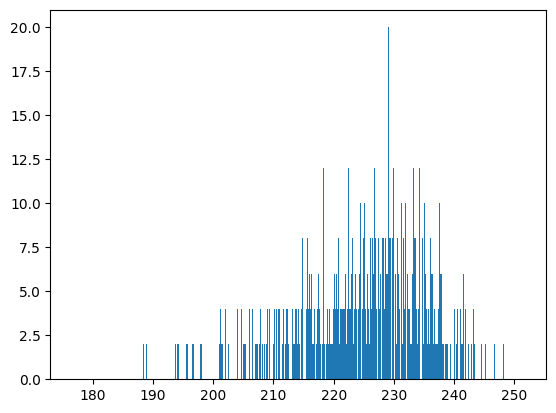

In [17]:
import matplotlib.pyplot as plt
(row, col) = np.nonzero(l2_norm_expression_list2)
l2_norm_non_zero_expression_list = l2_norm_expression_list2[row, col]
plt.hist(l2_norm_non_zero_expression_list, bins=2000)

# Calculating Among Users

In [12]:
highest_frequency_components_overall = highest_frequency_components_list + highest_frequency_components_list2
# L2 norm among highest frequency components after BDCT decomposition
num_images = len(highest_frequency_components_overall)

l2_norm_expression_list_overall = np.zeros((len(highest_frequency_components_overall),len(highest_frequency_components_overall)))
for i in range(num_images):
    for j in range(num_images):
        l2_norm_expression_list_overall[i][j] = np.linalg.norm(highest_frequency_components_overall[i] - highest_frequency_components_overall[j])

In [18]:
highest_frequency_components_overall[0].shape

torch.Size([1, 3, 256, 256])

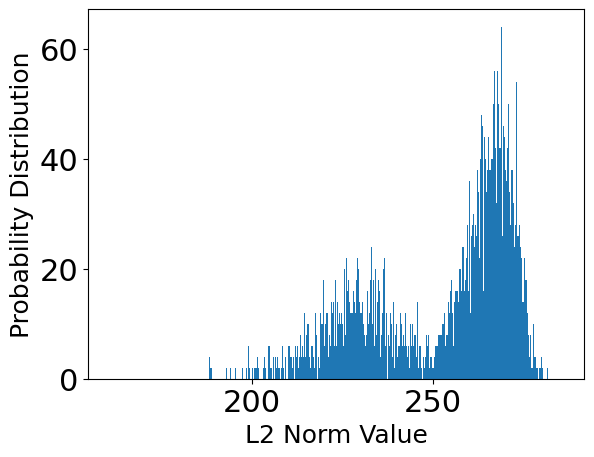

In [12]:
import matplotlib.pyplot as plt
(row, col) = np.nonzero(l2_norm_expression_list_overall)
l2_norm_non_zero_expression_list_overall = l2_norm_expression_list_overall[row, col]
plt.hist(l2_norm_non_zero_expression_list_overall, bins=2000)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("Probability Distribution", fontsize=SMALL_SIZE)
plt.xlabel("L2 Norm Value", fontsize=SMALL_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

# plt.legend(["zcu104", 'Alveo U280'])#, fontsize=SMALL_SIZE)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.savefig('L2_norm_of_high_frequency_component.pdf', bbox_inches="tight", transparent=True) 

plt.show()

In [ ]:
# Calculate the difference between high frequency components of two users and downsample images of the original expressions.

# Calculate Adversarial Successful Rate

In [19]:
# User 1
overall_img_path_list = []
path_prefix = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/"
all_dir = os.listdir(path_prefix)
for sgl_dir in all_dir:
    path_average = os.path.join(path_prefix + sgl_dir, "average")
    overall_img_path_list.append(os.path.join(path_average, os.listdir(path_average)[0]))

highest_frequency_components_list = []
for img_path in overall_img_path_list:
    img_blocks = bdct_4x4(img_path)
    highest_frequency_components_list.append(img_blocks[:,:,-1,:,:])


# User 2
overall_img_path_list2 = []
path_prefix2 = "/scratch1/jianming/multiface/dataset/m--20180226--0000--6674443--GHS/unwrapped_uv_1024/"
all_dir = os.listdir(path_prefix2)
for sgl_dir in all_dir:
    path_average2 = os.path.join(path_prefix2 + sgl_dir, "average")
    overall_img_path_list2.append(os.path.join(path_average2, os.listdir(path_average2)[0]))

highest_frequency_components_list2 = []
for img_path in overall_img_path_list2:
    img_blocks = bdct_4x4(img_path)
    highest_frequency_components_list2.append(img_blocks[:,:,-1,:,:])


# Two users
highest_frequency_components_overall = highest_frequency_components_list + highest_frequency_components_list2
num_images = len(highest_frequency_components_overall)

In [20]:
downsample_shape = 4 # which should be the block size

# User 1
overall_img_path_list = []
path_prefix = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/"
all_dir = os.listdir(path_prefix)
for sgl_dir in all_dir:
    path_average = os.path.join(path_prefix + sgl_dir, "average")
    overall_img_path_list.append(os.path.join(path_average, os.listdir(path_average)[0]))

downsample_list = []
for img_path in overall_img_path_list:
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    x = transform(image).unsqueeze(0)
    downsample_img = transforms.Resize(size=int(x.shape[-1]/downsample_shape))(x)
    downsample_list.append(downsample_img)


# User 2
overall_img_path_list2 = []
path_prefix2 = "/scratch1/jianming/multiface/dataset/m--20180226--0000--6674443--GHS/unwrapped_uv_1024/"
all_dir = os.listdir(path_prefix2)
for sgl_dir in all_dir:
    path_average2 = os.path.join(path_prefix2 + sgl_dir, "average")
    overall_img_path_list2.append(os.path.join(path_average2, os.listdir(path_average2)[0]))

downsample_list2 = []
for img_path in overall_img_path_list2:
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    x = transform(image).unsqueeze(0)
    downsample_img = transforms.Resize(size=int(x.shape[-1]/downsample_shape))(x)
    downsample_list2.append(downsample_img)


# Two users
downsample_overall = downsample_list + downsample_list2
num_downsample_original_images = len(downsample_overall)

In [25]:
distance_calculation_reconstruct_origin = np.zeros((num_downsample_original_images, num_downsample_original_images))
for i in range(num_images):
    for j in range(num_images):
        distance_calculation_reconstruct_origin[i][j] = np.linalg.norm(highest_frequency_components_overall[i] - downsample_overall[j])

category_guess = []
for i in range(num_images):
    category_guess.append(np.argmin(distance_calculation_reconstruct_origin[i]))

number_correct_guess = 0
for i in range(num_images):
    if(category_guess[i] == i):
        number_correct_guess=number_correct_guess+1

print(f"overall correct guess number = {number_correct_guess}")
print(f"Correct guess ratio = {number_correct_guess/num_images}")

# Choose among all outsourced frequency componets 

In [11]:
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchjpeg import dct
# from scipy.fftpack import dct, idct
# import torch_dct as dct_2d, idct_2d
from PIL import Image
import os 
import torch
import torchvision.transforms as T

block_size = 4
total_frequency_components = block_size * block_size
check_reconstruct_img = True
save_block_img_to_drive = False

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension 

def img_reorder(x, bs, ch, h, w):
    x = (x + 1) / 2 * 255
    assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")
    x = dct.to_ycbcr(x)  # comvert RGB to YCBCR
    x -= 128
    x = x.view(bs * ch, 1, h, w)
    x = F.unfold(x, kernel_size=(block_size, block_size), dilation=1, padding=0, stride=(block_size, block_size))
    x = x.transpose(1, 2)
    x = x.view(bs, ch, -1, block_size, block_size)
    return x

## Image reordering and testing
def img_inverse_reroder(coverted_img, bs, ch, h, w):
    x = coverted_img.view(bs* ch, -1, total_frequency_components)
    x = x.transpose(1, 2)
    x = F.fold(x, output_size=(h, w), kernel_size=(block_size, block_size), stride=(block_size, block_size))
    x += 128
    x = x.view(bs, ch, h, w)
    x = dct.to_rgb(x)#.squeeze(0)
    x = (x / 255.0) * 2 - 1
    return x

## Image frequency cosine transform
def test_img_dct_transform_reorder_noise(x, bs, ch, h, w, freq_comp_lb):
    back_input = x
    rerodered_img = img_reorder(x, bs, ch, h, w)
    block_num = h // 4
    dct_block = dct.block_dct(rerodered_img) #BDCT
    dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, total_frequency_components).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)
    
    for i in range(freq_comp_lb):
        dct_block_reorder[:, :, i, :, :] = dct_block_reorder[:, :, freq_comp_lb, :, :]
 
    idct_dct_block_reorder = dct_block_reorder.view(bs, ch, total_frequency_components, block_num*block_num).permute(0, 1, 3, 2).view(bs, ch, block_num*block_num, block_size, block_size)
    inverse_dct_block = dct.block_idct(idct_dct_block_reorder) #inverse BDCT
    inverse_transformed_img = img_inverse_reroder(inverse_dct_block, bs, ch, h, w)
    print(torch.allclose(inverse_transformed_img, back_input, atol=1e-4))
    return inverse_transformed_img

<>:26: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:26: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:26: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_373155/3386080706.py:26: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")


In [13]:
test_img_path = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/E001_Neutral_Eyes_Open/average/000102.png"
test_image_tensor = load_image(img_path)
bs, ch, h, w = test_image_tensor.shape
test_inverse_transformed_img = test_img_dct_transform_reorder_noise(test_image_tensor, bs, ch, h, w, 0)

True


In [17]:
Test_list = []
for i in range(total_frequency_components-1):
    print(total_frequency_components-1-i)
    Test_list.append(total_frequency_components-1-i)
print(len(Test_list))

15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
15


In [ ]:
"""
    Obtain the outsourced images
"""

# User 1
overall_img_path_list_all_comp = []
total_frequency_components = 16
for i in range(total_frequency_components-1):
    overall_img_path_list = []
    path_prefix = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/"
    all_dir = os.listdir(path_prefix)
    for sgl_dir in all_dir:
        path_average = os.path.join(path_prefix + sgl_dir, "average")
        overall_img_path_list.append(os.path.join(path_average, os.listdir(path_average)[0]))

    image_list = []
    for img_path in overall_img_path_list:
        image_tensor = load_image(img_path)
        bs, ch, h, w = image_tensor.shape
        inverse_transformed_img = test_img_dct_transform_reorder_noise(image_tensor, bs, ch, h, w, total_frequency_components-1-i)
        image_list.append(inverse_transformed_img)

    # User 2
    overall_img_path_list2 = []
    path_prefix2 = "/scratch1/jianming/multiface/dataset/m--20180226--0000--6674443--GHS/unwrapped_uv_1024/"
    all_dir = os.listdir(path_prefix2)
    for sgl_dir in all_dir:
        path_average2 = os.path.join(path_prefix2 + sgl_dir, "average")
        overall_img_path_list2.append(os.path.join(path_average2, os.listdir(path_average2)[0]))

    image_list2 = []
    for img_path in overall_img_path_list2:
        image_tensor = load_image(img_path)
        bs, ch, h, w = image_tensor.shape
        inverse_transformed_img = test_img_dct_transform_reorder_noise(image_tensor, bs, ch, h, w, total_frequency_components-1-i)
        image_list2.append(inverse_transformed_img)

    overall_image_list = image_list + image_list2
    overall_img_path_list_all_comp.append(overall_image_list)

In [22]:
print(len(overall_img_path_list_all_comp))
print(len(overall_img_path_list_all_comp[0]))
print(overall_img_path_list_all_comp[0][0].shape)

15
131
torch.Size([1, 3, 1024, 1024])


In [23]:
"""
    Obtain the original image
"""

# User 1
overall_img_path_list = []
path_prefix = "/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/"
all_dir = os.listdir(path_prefix)
for sgl_dir in all_dir:
    path_average = os.path.join(path_prefix + sgl_dir, "average")
    overall_img_path_list.append(os.path.join(path_average, os.listdir(path_average)[0]))

image_list = []
for img_path in overall_img_path_list:
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    x = transform(image).unsqueeze(0)
    image_list.append(x)

# User 2
overall_img_path_list2 = []
path_prefix2 = "/scratch1/jianming/multiface/dataset/m--20180226--0000--6674443--GHS/unwrapped_uv_1024/"
all_dir = os.listdir(path_prefix2)
for sgl_dir in all_dir:
    path_average2 = os.path.join(path_prefix2 + sgl_dir, "average")
    overall_img_path_list2.append(os.path.join(path_average2, os.listdir(path_average2)[0]))

image_list2 = []
for img_path in overall_img_path_list2:
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    x = transform(image).unsqueeze(0)
    image_list2.append(x)

# Two users
image_overall = image_list + image_list2
num_image_original_images = len(image_overall)

In [37]:
import numpy as np
total_numerb_freq_components = 16 

def caculate_attack_successful_rate(image_list1, image_list2):
    num_images = len(image_list1)
    distance_calculation_reconstruct_origin = np.zeros((len(image_list1), len(image_list1)))
    for i in range(num_images):
        for j in range(num_images):
            distance_calculation_reconstruct_origin[i][j] = np.linalg.norm(image_list1[i] - image_list2[j])

    category_guess = []
    for i in range(num_images):
        category_guess.append(np.argmin(distance_calculation_reconstruct_origin[i]))

    number_correct_guess = 0
    for i in range(num_images):
        if(category_guess[i] == i):
            number_correct_guess=number_correct_guess+1

    print(f"overall correct guess number = {number_correct_guess}")
    print(f"Correct guess ratio = {number_correct_guess/num_images}")
    return number_correct_guess/num_images

In [38]:
empirical_successful_rate_under_all_categroies = []
for i in range(len(overall_img_path_list_all_comp)):
    psr = caculate_attack_successful_rate(image_overall, overall_img_path_list_all_comp[i])
    empirical_successful_rate_under_all_categroies.append(psr)
print(empirical_successful_rate_under_all_categroies)

overall correct guess number = 12
Correct guess ratio = 0.0916030534351145
overall correct guess number = 42
Correct guess ratio = 0.32061068702290074
overall correct guess number = 67
Correct guess ratio = 0.5114503816793893
overall correct guess number = 114
Correct guess ratio = 0.8702290076335878
overall correct guess number = 131
Correct guess ratio = 1.0
overall correct guess number = 131
Correct guess ratio = 1.0
overall correct guess number = 131
Correct guess ratio = 1.0
overall correct guess number = 131
Correct guess ratio = 1.0
overall correct guess number = 131
Correct guess ratio = 1.0
